# Search Parameter Optimization Simulation

In [ ]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib as mpl
from alphadia.workflow import manager

os.environ["NUMBA_BOUNDSCHECK"] = "1"
os.environ["NUMBA_DEVELOPER_MODE"] = "1"
os.environ["NUMBA_FULL_TRACEBACKS"] = "1"

In [ ]:
mpl.rcParams['figure.dpi']= 150

#%config InlineBackend.figure_format = 'svg'

# set all axis and text colors to #4e4f51
mpl.rcParams['text.color'] = '#4e4f51'
mpl.rcParams['axes.labelcolor'] = '#4e4f51'
mpl.rcParams['axes.edgecolor'] = '#4e4f51'
mpl.rcParams['xtick.color'] = '#4e4f51'
mpl.rcParams['ytick.color'] = '#4e4f51'

# change all default line widths
mpl.rcParams['lines.linewidth'] = 0.6
mpl.rcParams['axes.linewidth'] = 0.6
mpl.rcParams['xtick.major.width'] = 0.6
mpl.rcParams['ytick.major.width'] = 0.6
mpl.rcParams['xtick.minor.width'] = 0.6
mpl.rcParams['ytick.minor.width'] = 0.6

# Mock Calibration 

In [ ]:
config =  [{'name': 'precursor',
  'estimators': [{'name': 'rt',
    'model': 'LOESSRegression',
    'model_args': {'n_kernels': 6},
    'input_columns': ['rt_library'],
    'target_columns': ['rt_observed'],
    'output_columns': ['rt_calibrated'],
    },
]}]

config_calib_rt =  [{'name': 'precursor',
  'estimators': [{'name': 'rt',
    'model': 'CalibRT',
    'model_args': {},
    'input_columns': ['rt_library'],
    'target_columns': ['rt_observed'],
    'output_columns': ['rt_calibrated'],
    },
]}]

manager.CALIBRATION_MANAGER_CONFIG = config
calibration_manager = manager.CalibrationManager()

0:01:42.320059 INFO: Initializing CalibrationManager
0:01:42.320571 INFO: Loading calibration config
0:01:42.320913 INFO: Calibration config: [{'name': 'precursor', 'estimators': [{'name': 'rt', 'model': 'LOESSRegression', 'model_args': {'n_kernels': 6}, 'input_columns': ['rt_library'], 'target_columns': ['rt_observed'], 'output_columns': ['rt_calibrated']}]}]
0:01:42.321170 INFO: Calibration group :precursor, found 1 estimator(s)


In [ ]:
def find_precursors_at_01_FDR(rt_df, number_to_discover):

    # Only allow values within the tolerance to be discovered
    rt_df['discoverable'] = False
    rt_df["discoverable"] = rt_df.apply(lambda row: row['rt_observed'] < row["upper_bound"] and row['rt_observed'] > row['lower_bound'], axis=1)
    rt_df.loc[rt_df['discoverable'] == False, "discovered"] = False

    # Take a random sample at appropriate FDR of the remaining discoverable precursors
    target_indices = rt_df.loc[(rt_df['decoy'] == False) & (rt_df['discoverable'] == True) & (rt_df['discovered'] == False)].sample(n=int(0.99*number_to_discover)).index
    decoy_indices = rt_df.loc[(rt_df['decoy'] == True) & (rt_df['discoverable'] == True) & (rt_df['discovered'] == False)].sample(n=int(0.01*number_to_discover)).index
    rt_df.loc[target_indices, 'discovered'] = True
    rt_df.loc[decoy_indices, 'discovered'] = True

    return rt_df


In [ ]:
dataset_size = 3000
iterations = 15
update_rule = 0.99

true_amplitude = 60
true_wavelength = 100
true_noise = 50

rng = np.random.default_rng(42)
predicted_rt = rng.uniform(100, 1000, size=dataset_size)
observed_rt = predicted_rt + true_amplitude * np.sin(predicted_rt / true_wavelength) + rng.normal(0, true_noise, size=dataset_size)
true_rt = predicted_rt + true_amplitude * np.sin(predicted_rt / true_wavelength)
true_positive_95_bound = true_rt + 1.96 * true_noise
true_negative_95_bound = true_rt - 1.96 * true_noise

In [ ]:
rt_df_target = pd.DataFrame({"rt_library": predicted_rt, 
                             "rt_observed": observed_rt, 
                             "rt_true": true_rt, 
                             "rt_true_positive_95_bound": true_positive_95_bound,
                             "rt_true_negative_95_bound": true_negative_95_bound,
                             "decoy": False, 
                             "discovered": False})
rt_df_decoy = pd.DataFrame({"rt_library": predicted_rt, "rt_observed": rng.uniform(100, 1000, size=dataset_size), "decoy": True, "discovered": False})
rt_df = pd.concat([rt_df_target, rt_df_decoy]).reset_index(drop=True)
rt_df["lower_bound"] = rt_df["rt_library"] - 300
rt_df["upper_bound"] = rt_df["rt_library"] + 300

dfs = [rt_df.copy()]
tolerances = [300]

for i in range(iterations):
    print(i)
    
    rt_df = find_precursors_at_01_FDR(rt_df, 100).copy()
    
    precursor_df = rt_df[rt_df["discovered"]]
    calibration_manager.fit(precursor_df, "precursor")

    # Get upper and lower bounds for next search
    tolerance = calibration_manager.get_estimator(
        "precursor", "rt"
    ).ci(precursor_df, update_rule)

    calibration_manager.predict(rt_df, "precursor")

    rt_df['upper_bound'] = rt_df['rt_calibrated'] + tolerance
    rt_df['lower_bound'] = rt_df['rt_calibrated'] - tolerance

    tolerances.append(tolerance)
    dfs.append(rt_df.copy())

0:01:42.411905 INFO: calibration group: precursor, fitting rt estimator 
0:01:42.415518 INFO: calibration group: precursor, predicting rt
0:01:42.442650 INFO: calibration group: precursor, fitting rt estimator 
0:01:42.445316 INFO: calibration group: precursor, predicting rt
0:01:42.470872 INFO: calibration group: precursor, fitting rt estimator 
0:01:42.473066 INFO: calibration group: precursor, predicting rt
0:01:42.499471 INFO: calibration group: precursor, fitting rt estimator 
0:01:42.501854 INFO: calibration group: precursor, predicting rt
0:01:42.527652 INFO: calibration group: precursor, fitting rt estimator 
0:01:42.530212 INFO: calibration group: precursor, predicting rt
0:01:42.566556 INFO: calibration group: precursor, fitting rt estimator 
0:01:42.570127 INFO: calibration group: precursor, predicting rt


0
1
2
3
4
5
6


0:01:42.602170 INFO: calibration group: precursor, fitting rt estimator 
0:01:42.604882 INFO: calibration group: precursor, predicting rt
0:01:42.631466 INFO: calibration group: precursor, fitting rt estimator 
0:01:42.635726 INFO: calibration group: precursor, predicting rt
0:01:42.664146 INFO: calibration group: precursor, fitting rt estimator 
0:01:42.666718 INFO: calibration group: precursor, predicting rt
0:01:42.692421 INFO: calibration group: precursor, fitting rt estimator 
0:01:42.696517 INFO: calibration group: precursor, predicting rt
0:01:42.721915 INFO: calibration group: precursor, fitting rt estimator 
0:01:42.724483 INFO: calibration group: precursor, predicting rt
0:01:42.751780 INFO: calibration group: precursor, fitting rt estimator 
0:01:42.754533 INFO: calibration group: precursor, predicting rt
0:01:42.780657 INFO: calibration group: precursor, fitting rt estimator 
0:01:42.783217 INFO: calibration group: precursor, predicting rt
0:01:42.807731 INFO: calibration g

7
8
9
10
11
12
13


0:01:42.810789 INFO: calibration group: precursor, predicting rt
0:01:42.836908 INFO: calibration group: precursor, fitting rt estimator 
0:01:42.839858 INFO: calibration group: precursor, predicting rt


14


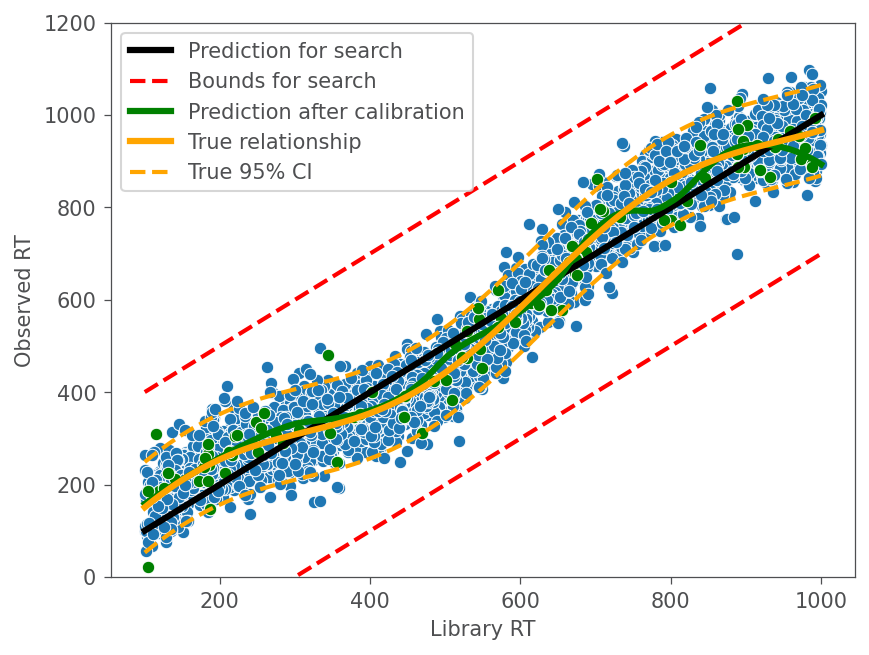

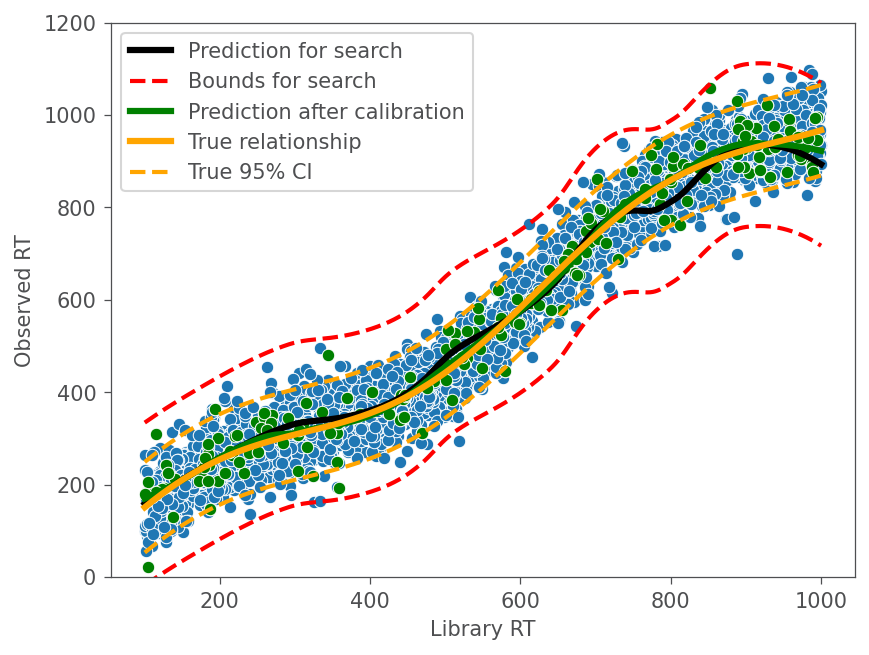

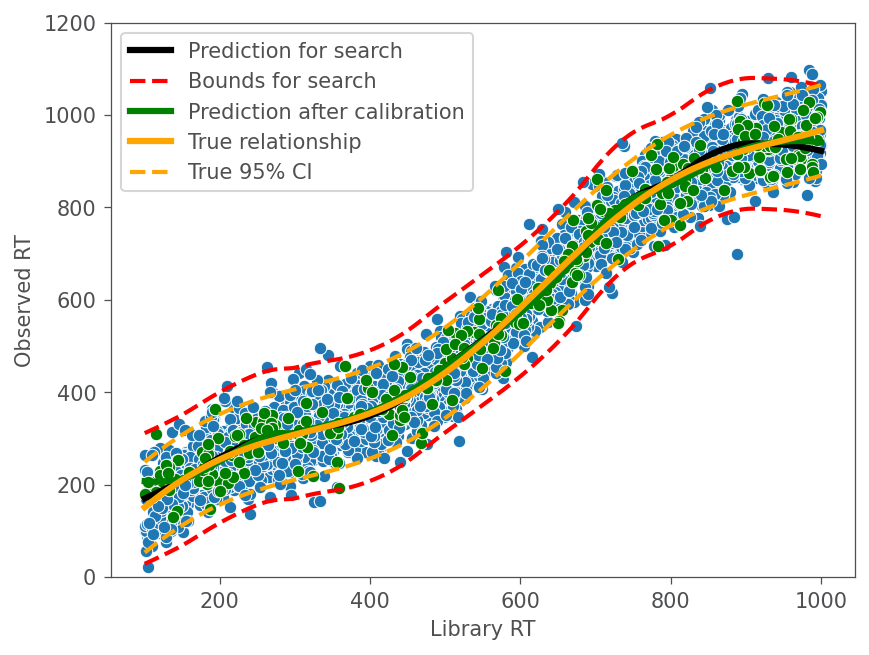

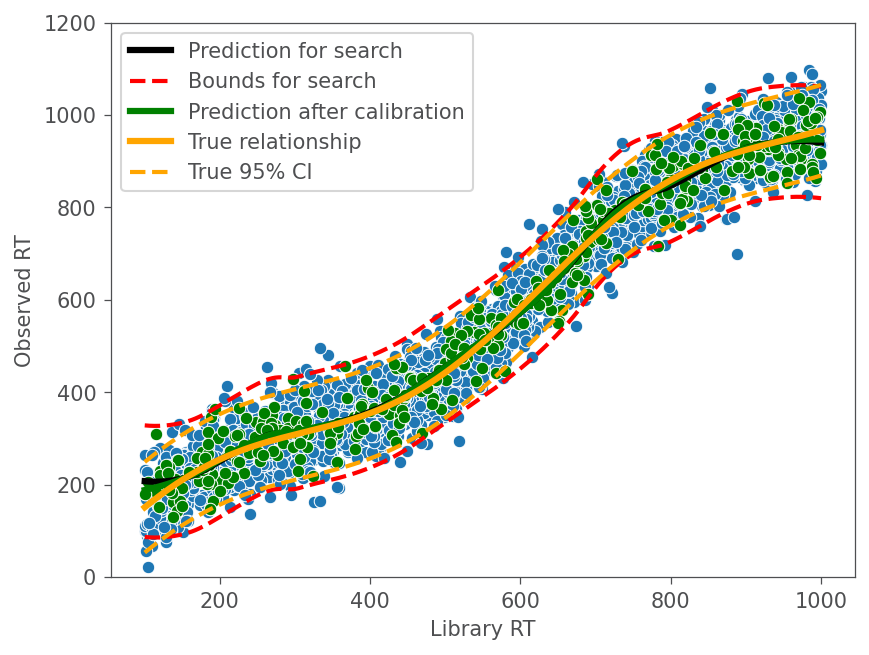

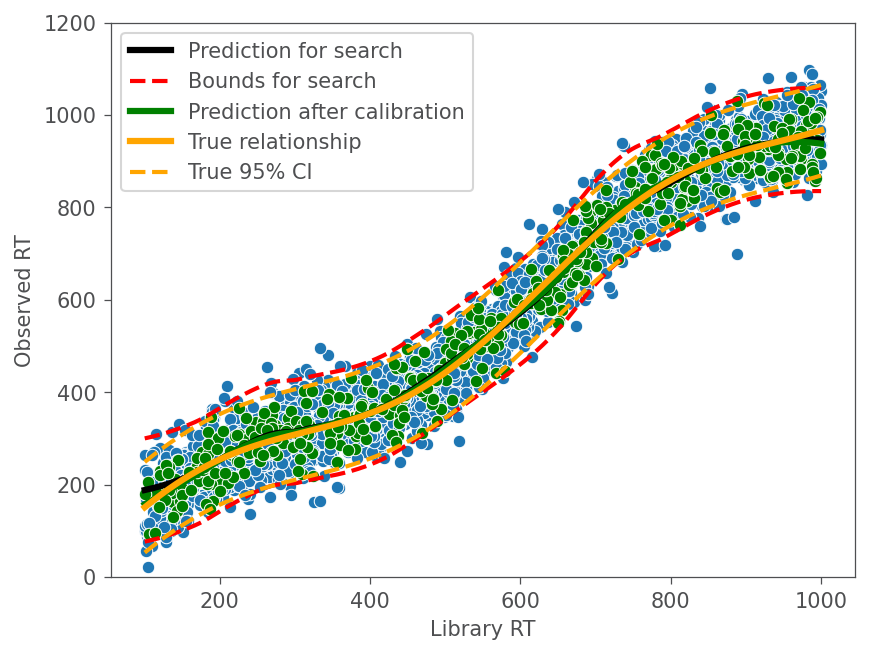

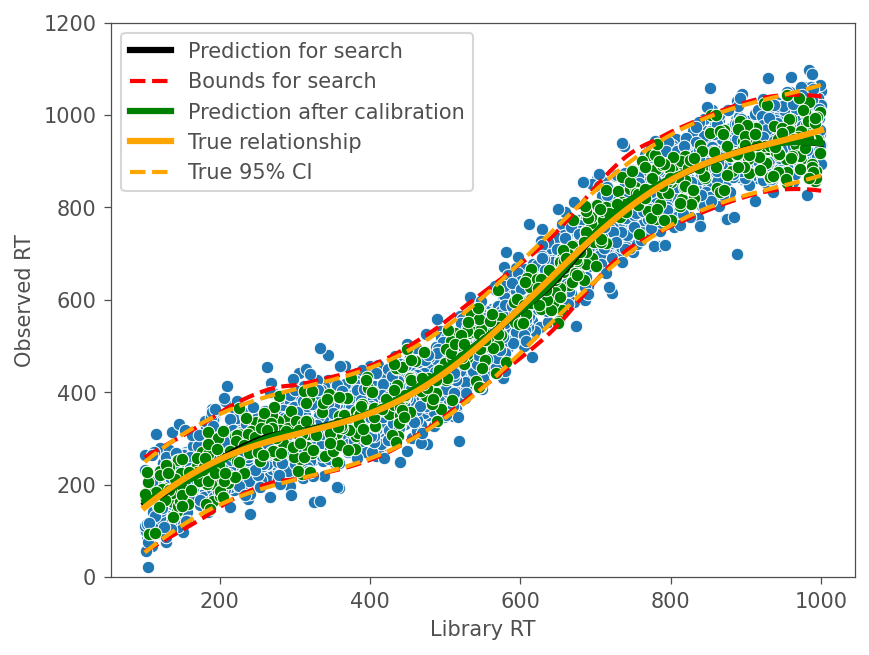

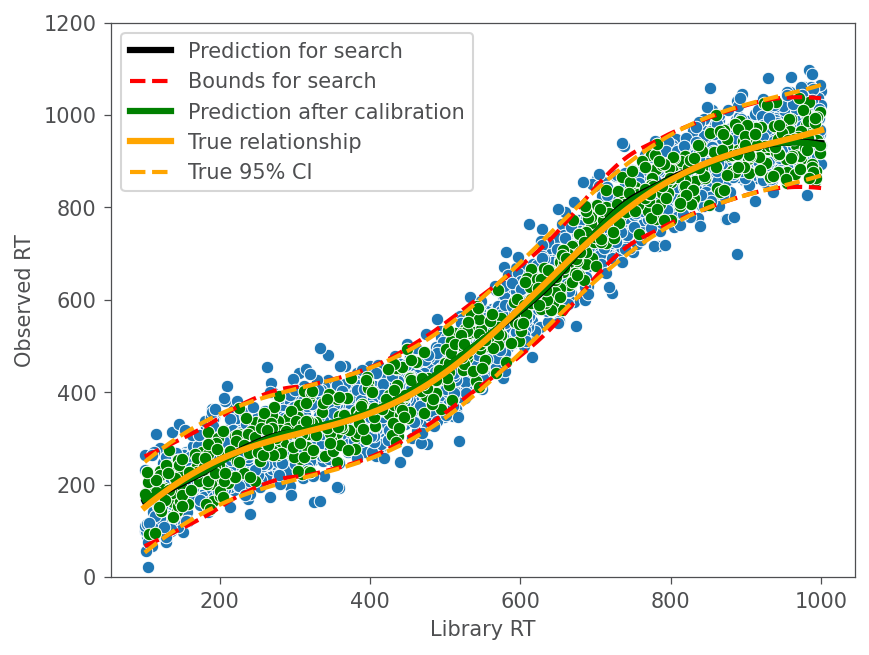

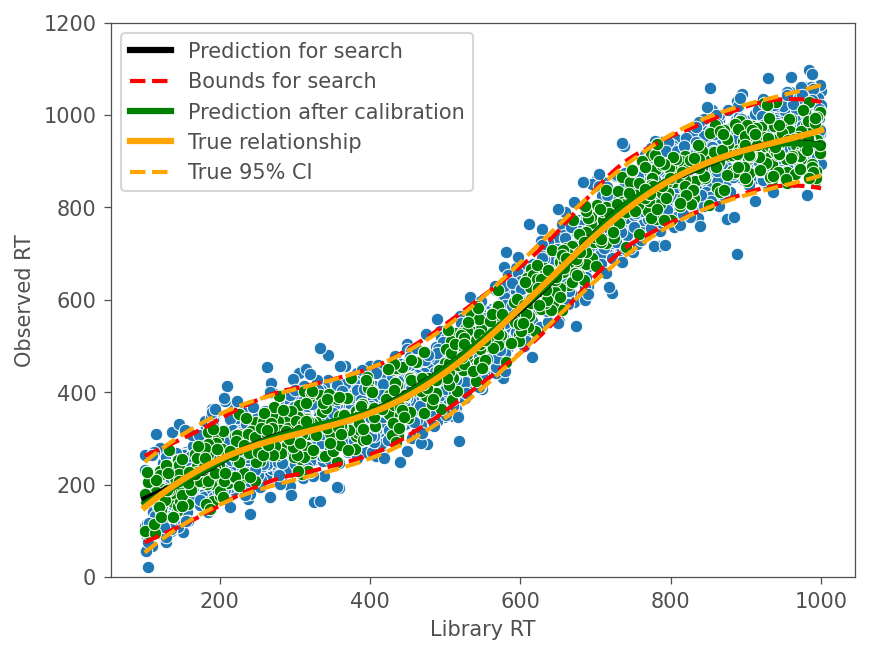

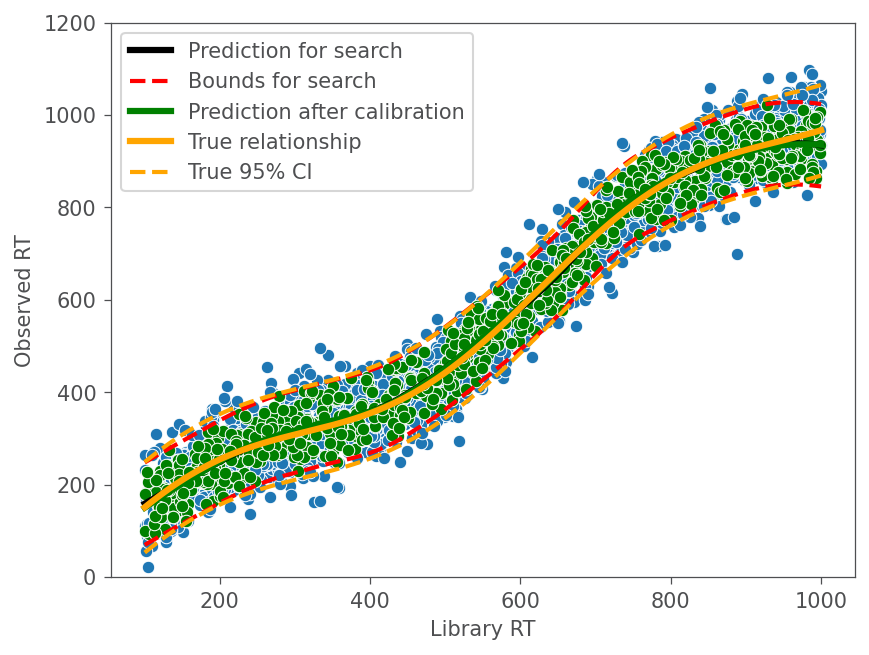

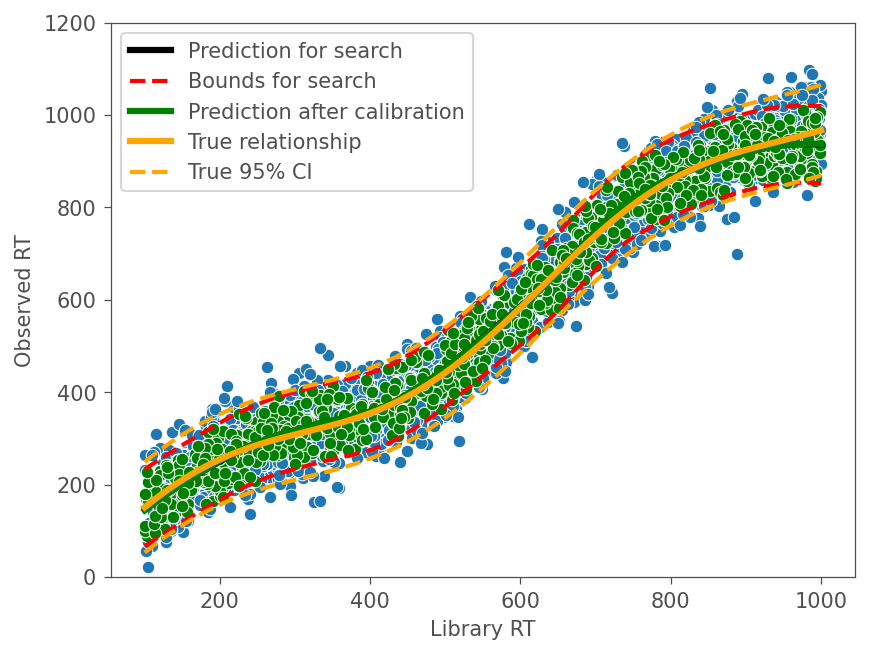

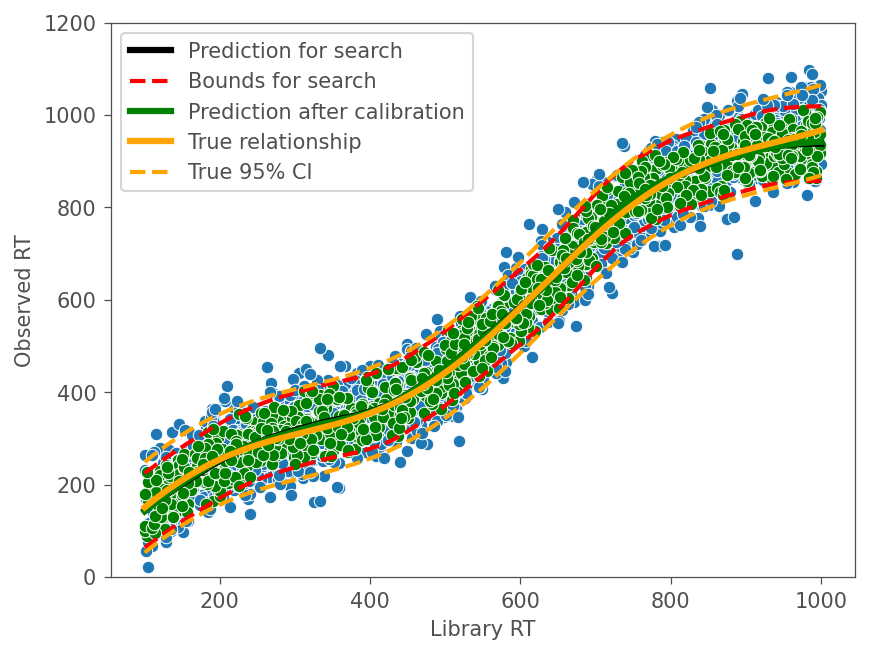

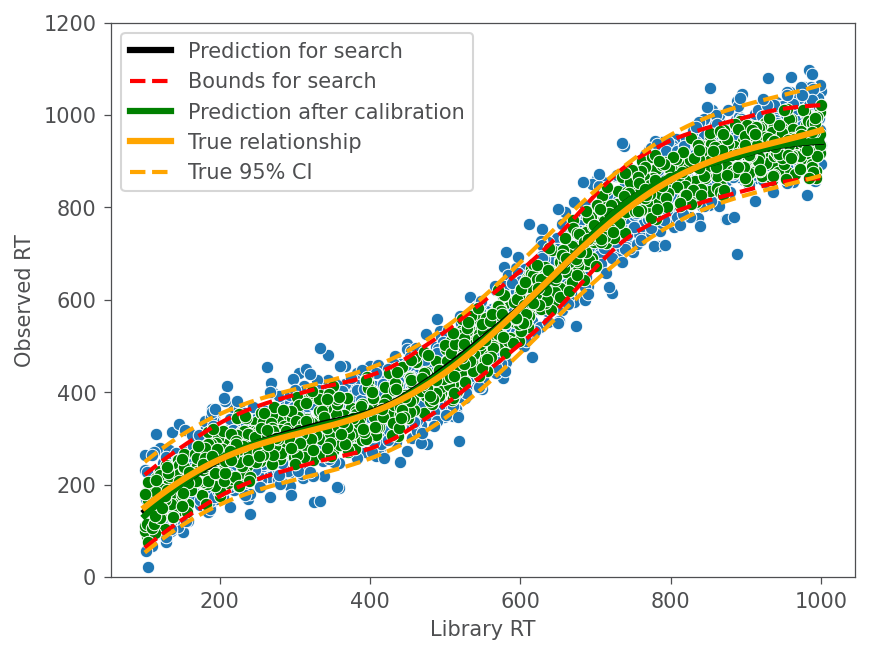

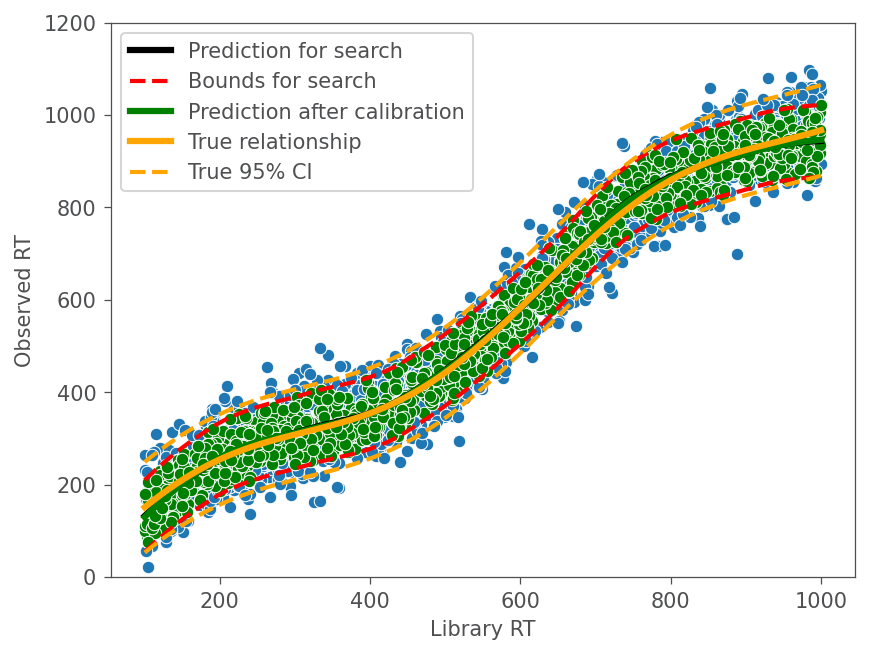

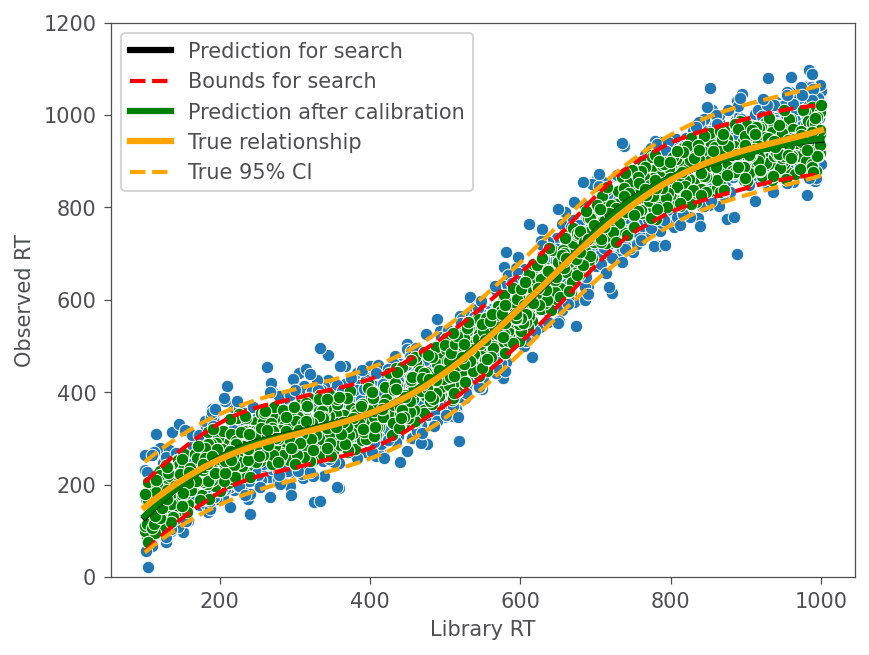

In [ ]:
show_ground_truth = True
show_decoys = False
show_search = True
show_discovered = True
show_calibration = True
show_true = True

for i in range(1, 15):

    prediction = "rt_calibrated" if i != 1 else "rt_library"
    previous_df = dfs[i-1]
    current_df = dfs[i]

    fig, ax = plt.subplots()

    # Ground truth
    if show_ground_truth:
        sns.scatterplot(data=rt_df[rt_df.decoy == False], x="rt_library", y='rt_observed', ax=ax)
        if show_decoys:
            sns.scatterplot(data=rt_df[rt_df.decoy == True], x="rt_library", y='rt_observed', ax=ax, color='red')
            legend_elements = [
                mpl.lines.Line2D([0], [0], marker='o', color='w', label='Target', markerfacecolor='#1f77b4', markersize=10),
                mpl.lines.Line2D([0], [0], marker='o', color='w', label='Decoy', markerfacecolor='red', markersize=10),
            ]
            ax.legend(handles=legend_elements, loc='upper right')

    # Search values
    if show_search:
        sns.lineplot(data=previous_df, x="rt_library", y=prediction, ax=ax, color='black', linewidth=3, errorbar=None,
                    label="Prediction for search")
        sns.lineplot(data=previous_df, x="rt_library", y="upper_bound", ax=ax, color='red', linestyle="--", linewidth=2, errorbar=None,
                    label="Bounds for search")
        sns.lineplot(data=previous_df, x="rt_library", y="lower_bound", ax=ax, color='red', linestyle="--", linewidth=2, errorbar=None)

    # Calibrated values
    if show_discovered:
        sns.scatterplot(data=current_df[(current_df.decoy == False) & (current_df.discovered == True)], x="rt_library", y='rt_observed', ax=ax, color='green')
    if show_calibration: 
        sns.lineplot(data=current_df, x="rt_library", y='rt_calibrated', ax=ax, color='green', linewidth=3, errorbar=None,
                    label="Prediction after calibration")

    

    # True relationship
    if show_true:
        sns.lineplot(data=rt_df, x="rt_library", y="rt_true", ax=ax, color='orange', linewidth=3, errorbar=None,
                    label="True relationship")
        sns.lineplot(data=rt_df, x="rt_library", y="rt_true_positive_95_bound", ax=ax, color='orange', linewidth=2, linestyle="--", errorbar=None, 
                    label="True 95% CI")
        sns.lineplot(data=rt_df, x="rt_library", y="rt_true_negative_95_bound", ax=ax, color='orange', linewidth=2, linestyle="--", errorbar=None)
        
#    ax.set_title(f"Iteration {i}. Precursor count: {current_df['discovered'].sum()}. Proportion Discoverable: {current_df.loc[current_df['decoy'] == False, 'discoverable'].sum() / dataset_size :.3f}")
    ax.set_ylim(bottom=0, top=1200)
    ax.set_ylabel("Observed RT")
    ax.set_xlabel("Library RT")
    plt.show()

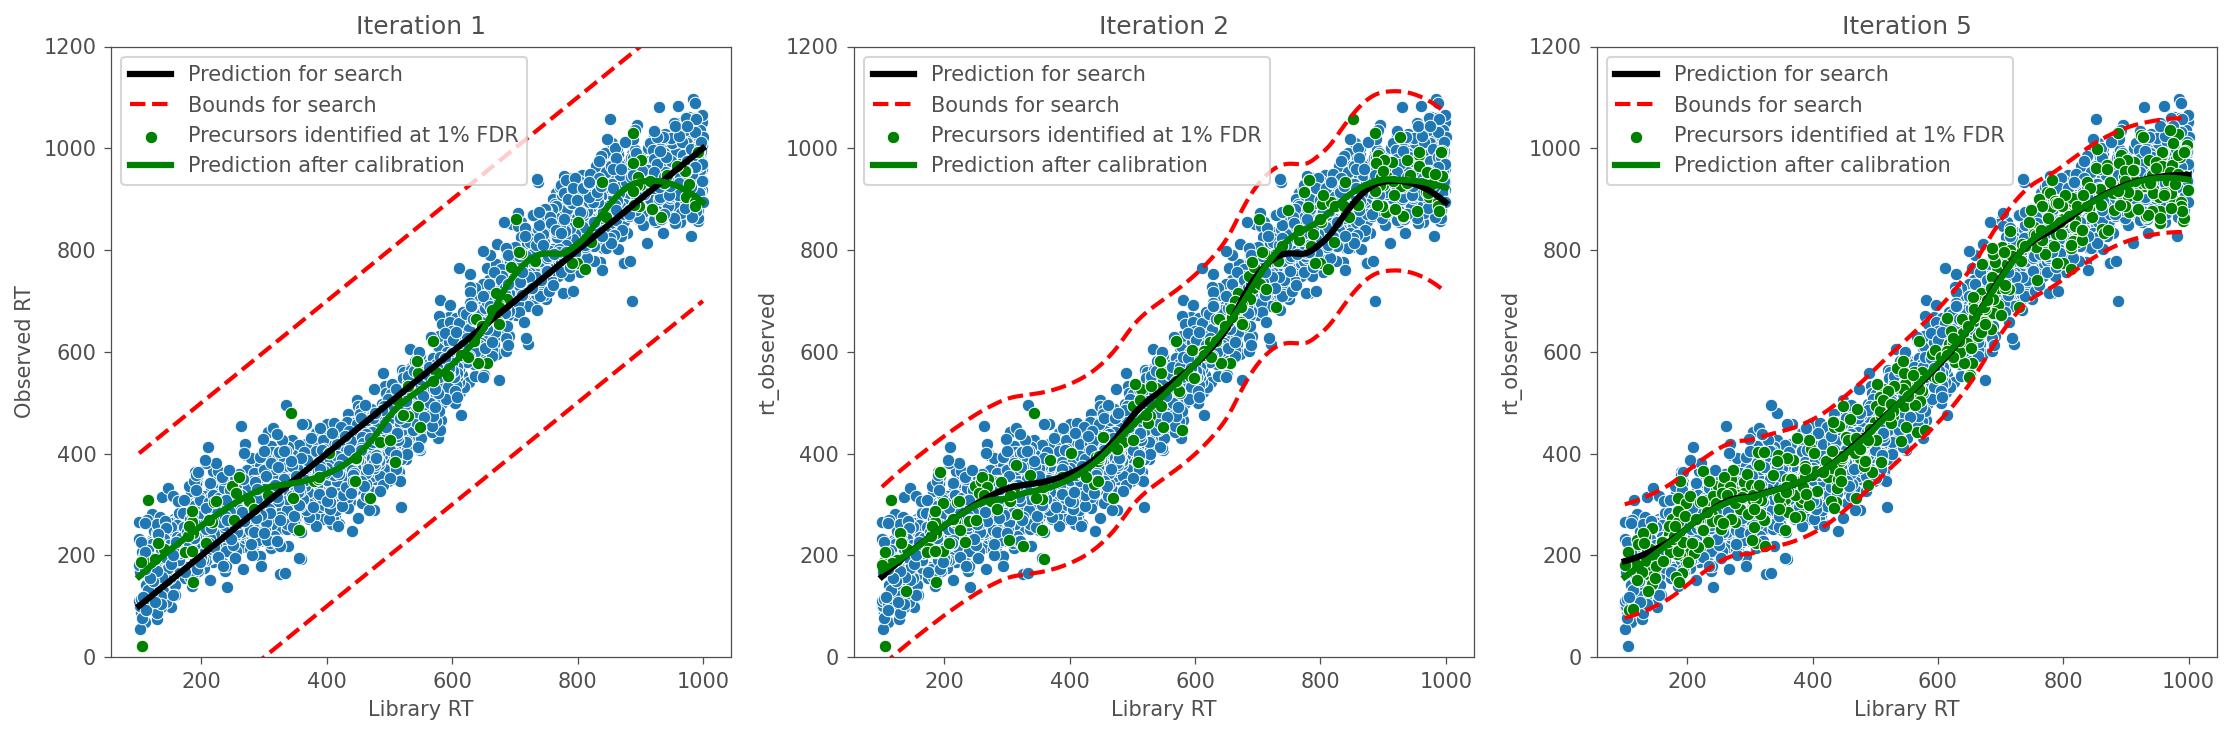

In [ ]:
show_ground_truth = True
show_decoys = False
show_search = True
show_discovered = True
show_calibration = True
show_true = False
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for j, i in enumerate([1, 2, 5]):

    prediction = "rt_calibrated" if i != 1 else "rt_library"
    previous_df = dfs[i-1]
    current_df = dfs[i]

    

    # Ground truth
    if show_ground_truth:
        sns.scatterplot(data=rt_df[rt_df.decoy == False], x="rt_library", y='rt_observed', ax=ax[j])
        if show_decoys:
            sns.scatterplot(data=rt_df[rt_df.decoy == True], x="rt_library", y='rt_observed', ax=ax[j], color='red')
            legend_elements = [
                mpl.lines.Line2D([0], [0], marker='o', color='w', label='Target', markerfacecolor='#1f77b4', markersize=10),
                mpl.lines.Line2D([0], [0], marker='o', color='w', label='Decoy', markerfacecolor='red', markersize=10),
            ]
            ax[j].legend(handles=legend_elements, loc='upper right')

    # Search values
    if show_search:
        sns.lineplot(data=previous_df, x="rt_library", y=prediction, ax=ax[j], color='black', linewidth=3, errorbar=None,
                    label="Prediction for search")
        sns.lineplot(data=previous_df, x="rt_library", y="upper_bound", ax=ax[j], color='red', linestyle="--", linewidth=2, errorbar=None,
                    label="Bounds for search")
        sns.lineplot(data=previous_df, x="rt_library", y="lower_bound", ax=ax[j], color='red', linestyle="--", linewidth=2, errorbar=None)

    # Calibrated values
    if show_discovered:
        sns.scatterplot(data=current_df[(current_df.decoy == False) & (current_df.discovered == True)], x="rt_library", y='rt_observed', ax=ax[j], color='green', label="Precursors identified at 1% FDR")
    if show_calibration: 
        sns.lineplot(data=current_df, x="rt_library", y='rt_calibrated', ax=ax[j], color='green', linewidth=3, errorbar=None,
                    label="Prediction after calibration")

    

    # True relationship
    if show_true:
        sns.lineplot(data=rt_df, x="rt_library", y="rt_true", ax=ax[j], color='orange', linewidth=3, errorbar=None,
                    label="True relationship")
        # sns.lineplot(data=rt_df, x="rt_library", y="rt_true_positive_95_bound", ax=ax[j], color='orange', linewidth=2, linestyle="--", errorbar=None, 
        #             label="True 95% CI")
        # sns.lineplot(data=rt_df, x="rt_library", y="rt_true_negative_95_bound", ax=ax[j], color='orange', linewidth=2, linestyle="--", errorbar=None)
        
#    ax.set_title(f"Iteration {i}. Precursor count: {current_df['discovered'].sum()}. Proportion Discoverable: {current_df.loc[current_df['decoy'] == False, 'discoverable'].sum() / dataset_size :.3f}")
    ax[j].set_ylim(bottom=0, top=1200)
    ax[0].set_ylabel("Observed RT")
    ax[j].set_xlabel("Library RT")
    ax[j].set_title(f"Iteration {i}")

plt.tight_layout()
plt.show()

In [ ]:
number_name = "Number of precursors"
proportion_name = "Proportion of precursors"

optimization_batches = pd.DataFrame({
    "Batch size": [
        8000, # 1
        24000, # 2
        56000, # 3
        56000, # 4
        56000, # 5
        24000, # 6
        8000, # 7
        24000, # 8
        24000, # 9
        8000], # 10
    proportion_name: [
        0.0005, # 1
        0.003, # 2
        0.005, # 3
        0.006, # 4
        0.010, # 5
        0.030, # 6
        0.020, # 7
        0.024, # 8
        0.04, # 9
        0.05 # 10
        ],
    "Optimization iteration": [
        1,
        1,
        1,
        2,
        3,
        4,
        5,
        5,
        6,
        7,
    ],
    "Number of batch steps tried": [
        1,
        2,
        3,
        1,
        1,
        1,
        1,
        2,
        1,
        1,
    ],
    "taken_for_calibration": [
        False,
        False,
        True,
        True, 
        True, 
        True, 
        False,
        True, 
        True,
        True],
})

optimization_batches[number_name] = optimization_batches["Batch size"] * optimization_batches[proportion_name]
optimization_batches["Requisite proportion"] = 200 / optimization_batches["Batch size"]

0:02:06.498150 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
0:02:06.501695 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


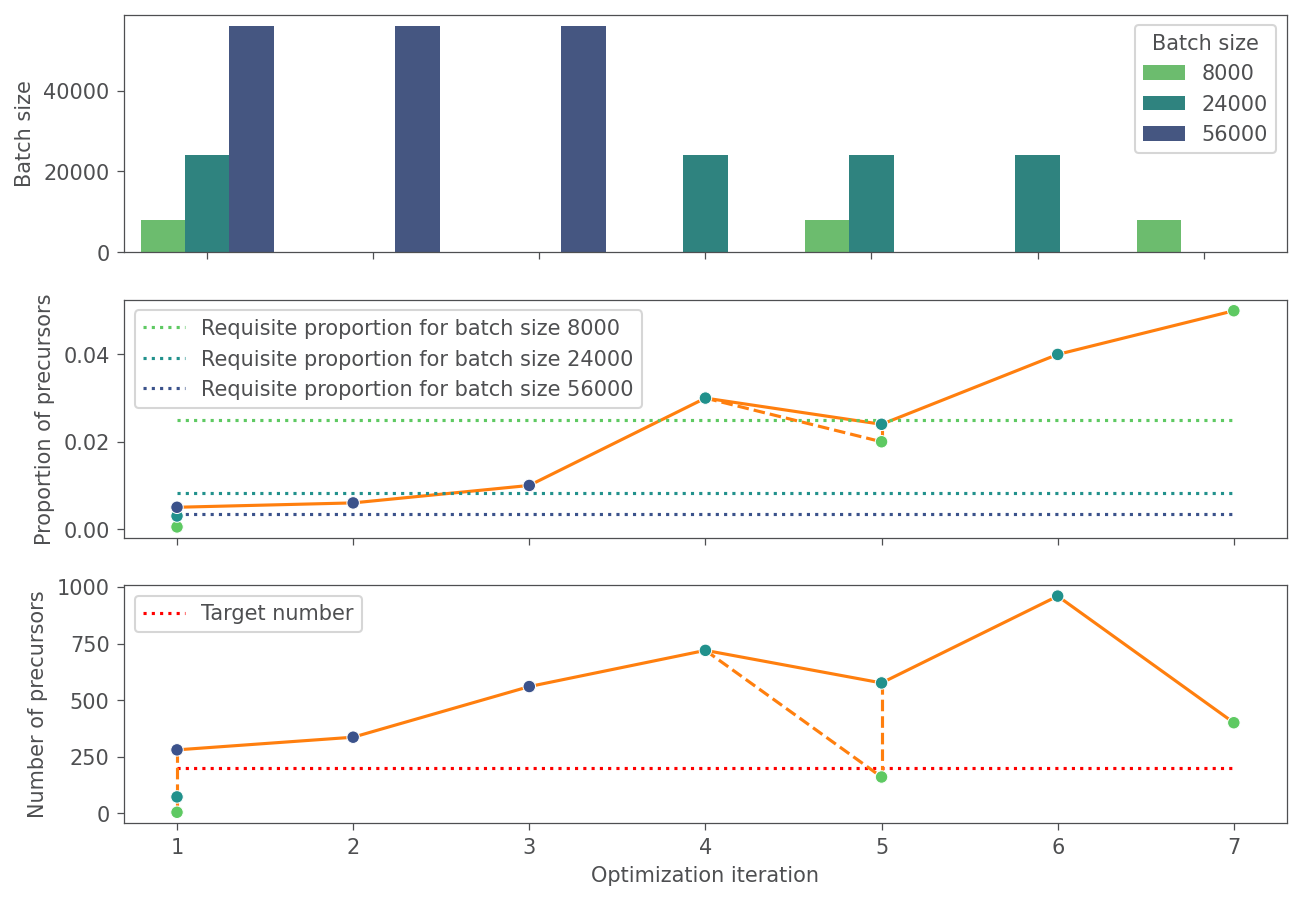

In [ ]:
line_colour = "#ff7f0e"
line_width = 1.5

fig, ax = plt.subplots(3, 1, figsize=(10, 7))  
palette=sns.color_palette("viridis", 3)[::-1]
sns.barplot(
    data=optimization_batches, 
    x="Optimization iteration", 
    y="Batch size", 
    hue="Batch size", 
    palette=palette,
    ax=ax[0],
    )

sns.lineplot(
    data=optimization_batches.loc[optimization_batches["taken_for_calibration"] == True], 
    x="Optimization iteration", 
    y=proportion_name, 
    c="#ff7f0e",
    legend=False,
    lw=line_width,
    ax=ax[1]
    )

sns.scatterplot(
    data=optimization_batches, 
    x="Optimization iteration", 
    y=proportion_name, 
    legend=False,
    hue="Batch size", 
    palette=palette,
    zorder=10,
    ax=ax[1]
    )
for i, val in enumerate(np.sort(optimization_batches["Requisite proportion"].unique())[::-1]):
    batch_size = np.sort(optimization_batches["Batch size"].unique())[i]
    ax[1].hlines(val, 1, 7, color=palette[i], linestyle=':', lw=line_width, label="Requisite proportion for batch size " + str(batch_size))

sns.lineplot(
    data=optimization_batches.loc[optimization_batches["taken_for_calibration"] == True], 
    x="Optimization iteration", 
    y=number_name, 
    c="#ff7f0e",
    ax=ax[2],
    lw=line_width,
    legend=False,
    )



sns.scatterplot(
    data=optimization_batches, 
    x="Optimization iteration", 
    y=number_name, 
    hue="Batch size", 
    legend=False,
    palette=palette,
    ax=ax[2],
    zorder=10,
    )
ax[2].hlines(200, 1, 7, color='red', linestyle=':', lw=line_width, label="Target number")


sns.lineplot(
    data=optimization_batches.loc[(optimization_batches["Number of batch steps tried"] == 1) &
                                  (optimization_batches["Optimization iteration"].isin([4, 5]))], 
    x="Optimization iteration", 
    y=number_name, 
    c="#ff7f0e",
    linestyle="--",
    lw=line_width,
    ax=ax[2]
    )

sns.lineplot(
    data=optimization_batches.loc[(optimization_batches["Number of batch steps tried"] == 1) &
                                  (optimization_batches["Optimization iteration"].isin([4, 5]))], 
    x="Optimization iteration", 
    y=proportion_name, 
    c="#ff7f0e",
    linestyle="--",
    lw=line_width,
    ax=ax[1]
    )


for i, optimization_number in enumerate(optimization_batches["Optimization iteration"].unique()):
    ax[1].vlines(
        optimization_number, 
        optimization_batches[optimization_batches["Optimization iteration"] == optimization_number][proportion_name].min(), 
        optimization_batches[optimization_batches["Optimization iteration"] == optimization_number][proportion_name].max(), 
        color='#ff7f0e', 
        lw=line_width,
        linestyle='--')
    
    ax[2].vlines(
        optimization_number, 
        optimization_batches[optimization_batches["Optimization iteration"] == optimization_number][number_name].min(), 
        optimization_batches[optimization_batches["Optimization iteration"] == optimization_number][number_name].max(), 
        color='#ff7f0e', 
        lw=line_width,
        linestyle='--')


ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
plt.show()